## Import Required Libraries

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from phantominator import shepp_logan

## Original vs Modified Shepp-Logan

The original Shepp-Logan phantom and the modified version with better contrast:

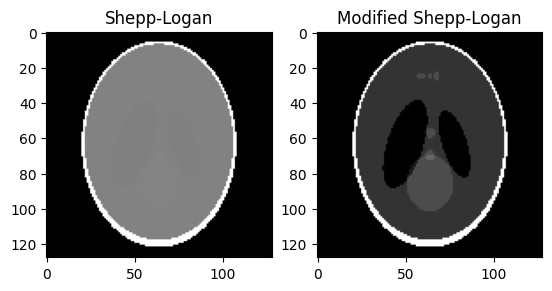

In [32]:
# The original Shepp-Logan
ph = shepp_logan(128, modified=False)
plt.subplot(1, 2, 1)
plt.title('Shepp-Logan')
plt.imshow(ph, cmap='gray')

# Modified Shepp-Logan for better contrast
ph = shepp_logan(128, modified=True)
plt.subplot(1, 2, 2)
plt.title('Modified Shepp-Logan')
plt.imshow(ph, cmap='gray')
plt.show()

## Non-Square Phantom

Generate a phantom with different width and height dimensions:

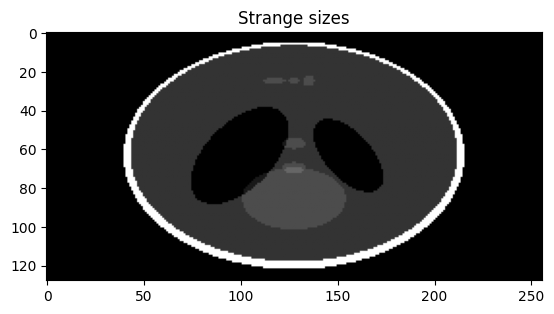

In [33]:
# Generate phantoms with different sizes
ph = shepp_logan((128, 256))
plt.title('Strange sizes')
plt.imshow(ph, cmap='gray')
plt.show()

## 3D Phantom

Create a 3D phantom and display all slices:

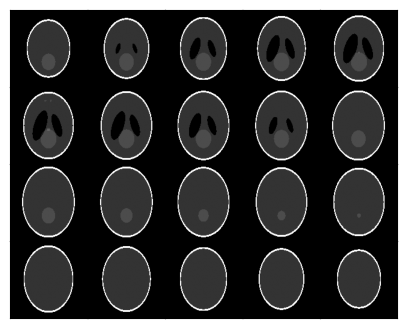

In [34]:
# Get a 3D phantom
ph = shepp_logan((128, 128, 20), zlims=(-.5, .5))

# Fancy dancing to nicely show all slices on same plot
nx = int(np.ceil(np.sqrt(ph.shape[-1])))
fig = plt.figure(figsize=(nx, nx))
for ii in range(ph.shape[-1]):
    ax = fig.add_subplot(nx, nx, ii+1)
    plt.imshow(ph[..., ii], cmap='gray')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_aspect('equal')
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Generate Dataset

Generate multiple Shepp-Logan phantom samples and save them as PNG files:

In [35]:
import os
import json
import re

# Configuration
phantom_type = 'modified'  # 'original' or 'modified'
nsamples = 1000  # Number of NEW samples to generate
image_size = 128  # Size of the phantom

# LoRA dataset output (images + metadata.jsonl)
output_folder = 'generated_data'
images_dir = output_folder  # Save images directly into output_folder (no subfolder)
metadata_jsonl_path = os.path.join(output_folder, 'metadata.jsonl')

# Prompt style for captions
prompt_style = 'detailed'  # 'simple', 'detailed', or 'medical'
# - simple: "synthetic Shepp-Logan brain phantom, enlarged ventricles"
# - detailed: "A synthetic CT-style Shepp-Logan brain phantom showing enlarged ventricles"
# - medical: "Synthetic CT-style Shepp-Logan brain phantom, enlarged ventricles"

# Anatomical variation parameters - simulate different brain anatomies
vary_brain_size = True  # Vary overall brain size
brain_size_range = (0.85, 1.15)  # Scale factor range for brain size

vary_ventricles = True  # Vary ventricle (fluid cavity) size
ventricle_size_range = (0.7, 2.0)  # Larger range for more variation

vary_white_matter = True  # Vary white matter structure
white_matter_range = (0.8, 1.3)  # White matter variation

vary_tumors = True  # Vary tumor/lesion sizes (small ellipses)
tumor_range = (0.5, 1.8)  # Tumor size variation

vary_shape_elongation = True  # Vary ellipse elongation (aspect ratio)
elongation_std = 0.1  # Standard deviation for aspect ratio changes

vary_rotation = True  # Vary rotation angles of ellipses
rotation_std = 10  # Degrees of rotation variation

vary_position = True  # Shift positions of internal structures
position_std = 0.04  # Position shift standard deviation

vary_intensity = True  # Vary tissue intensities slightly
intensity_std = 0.08  # Intensity variation

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Base seed: each sample uses a deterministic per-sample RNG (seed + sample_id).
# This avoids duplicating images when you re-run and skip existing files.
seed = 42

# Get base ellipse parameters
modified = phantom_type == 'modified'
base_phantom = shepp_logan(image_size, modified=modified, ret_E=True)
_, E_base = base_phantom

# Useful descriptor: keeps captions consistent and honest (synthetic phantom, not a real photo)
style_desc = 'CT-style' if modified else 'standard'

def _existing_png_indices(folder: str) -> list[int]:
    indices: list[int] = []
    if not os.path.isdir(folder):
        return indices
    for name in os.listdir(folder):
        if not name.lower().endswith('.png'):
            continue
        m = re.fullmatch(r'(\d+)\.png', name)
        if m is None:
            continue
        indices.append(int(m.group(1)))
    return indices

def _existing_metadata_filenames(path: str) -> set[str]:
    existing: set[str] = set()
    if not os.path.exists(path):
        return existing
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                row = json.loads(line)
            except json.JSONDecodeError:
                continue
            if isinstance(row, dict) and 'file_name' in row:
                existing.add(str(row['file_name']))
    return existing

existing_indices = _existing_png_indices(images_dir)
start_index = (max(existing_indices) + 1) if existing_indices else 1
existing_meta_files = _existing_metadata_filenames(metadata_jsonl_path)

# Width for zero-padding (keeps filenames stable even after many samples)
max_index_this_run = start_index + nsamples - 1
pad_width = max(4, len(str(max_index_this_run)))

mode = 'a' if os.path.exists(metadata_jsonl_path) else 'w'
print("Generating different 'brain' anatomies with multiple variations...\n")
print(f"Caption style: {prompt_style}")
print(f"Dataset folder: {output_folder}")
print(f"Images folder: {images_dir}")
print(f"Metadata file: {metadata_jsonl_path} (mode={mode})")
print(f"Existing PNGs found: {len(existing_indices)}")
print(f"Starting at index: {start_index}\n")

created = 0
skipped_existing = 0

# Generate and save samples with anatomical variations
with open(metadata_jsonl_path, mode) as jsonl_file:
    for j in range(nsamples):
        file_index = start_index + j
        file_name = f"{file_index:0{pad_width}d}.png"
        output_path = os.path.join(images_dir, file_name)

        # If the image already exists, do not recreate it (and do not duplicate metadata).
        if os.path.exists(output_path):
            skipped_existing += 1
            continue

        # Use a per-sample RNG so new files are truly new even across re-runs.
        sample_id = file_index - 1
        rng = np.random.default_rng(seed + sample_id)

        # Copy base parameters
        E = E_base.copy()

        # Dictionary to store metadata about this sample (optional: for debugging/repro)
        metadata = {
            'sample_id': int(sample_id),
            'phantom_type': phantom_type,
            'image_size': image_size,
            'seed': int(seed),
            'variations': {}
        }

        # Keep ellipse 0 (outermost/background) unchanged to maintain consistent background
        # Only vary internal structures (ellipses 1-9)

        # 1. Vary overall brain size (ellipses 1-3: inner skull, CSF, brain tissue)
        if vary_brain_size:
            brain_scale = rng.uniform(*brain_size_range)
            metadata['variations']['brain_size_scale'] = float(brain_scale)
            for idx in [1, 2, 3]:
                E[idx, 1] *= brain_scale  # major axis
                E[idx, 2] *= brain_scale  # minor axis

        # 2. Vary ventricle sizes (ellipses 4, 5 are lateral ventricles)
        ventricle_scales = []
        if vary_ventricles:
            # Each ventricle can vary independently
            for idx in [4, 5]:
                ventricle_scale = rng.uniform(*ventricle_size_range)
                ventricle_scales.append(float(ventricle_scale))
                E[idx, 1] *= ventricle_scale
                E[idx, 2] *= ventricle_scale
            metadata['variations']['ventricle_scales'] = ventricle_scales

        # 3. Vary white matter (ellipse 6)
        if vary_white_matter:
            wm_scale = rng.uniform(*white_matter_range)
            metadata['variations']['white_matter_scale'] = float(wm_scale)
            E[6, 1] *= wm_scale
            E[6, 2] *= wm_scale

        # 4. Vary tumor/small structure sizes (ellipses 7-9)
        tumor_scales = []
        if vary_tumors and E.shape[0] > 7:
            for idx in range(7, min(10, E.shape[0])):
                tumor_scale = rng.uniform(*tumor_range)
                tumor_scales.append(float(tumor_scale))
                E[idx, 1] *= tumor_scale
                E[idx, 2] *= tumor_scale
            metadata['variations']['tumor_scales'] = tumor_scales

        # 5. Vary shape elongation (aspect ratio) for internal structures
        if vary_shape_elongation:
            metadata['variations']['shape_elongation'] = True
            for idx in range(1, E.shape[0]):
                elongation_factor = rng.normal(1.0, elongation_std)
                E[idx, 2] *= elongation_factor

        # 6. Vary rotation angles
        if vary_rotation:
            metadata['variations']['rotation_applied'] = True
            for idx in range(1, E.shape[0]):
                angle_delta = rng.normal(0, np.deg2rad(rotation_std))
                E[idx, 5] += angle_delta

        # 7. Add position shifts for internal structures
        if vary_position:
            metadata['variations']['position_shifts'] = True
            E[1:, 3] += rng.normal(0, position_std, E.shape[0]-1)
            E[1:, 4] += rng.normal(0, position_std, E.shape[0]-1)

        # 8. Vary tissue intensities
        if vary_intensity:
            metadata['variations']['intensity_variation'] = True
            for idx in range(1, E.shape[0]):
                intensity_factor = rng.normal(1.0, intensity_std)
                E[idx, 0] *= intensity_factor

        # Generate descriptive features for caption
        features = []

        # Brain size descriptor
        if vary_brain_size:
            if brain_scale > 1.08:
                features.append("large brain")
            elif brain_scale < 0.92:
                features.append("small brain")
            else:
                features.append("normal-sized brain")

        # Ventricle descriptor
        if vary_ventricles:
            avg_ventricle = float(np.mean(ventricle_scales))
            if avg_ventricle > 1.3:
                features.append("significantly enlarged ventricles")
            elif avg_ventricle > 1.1:
                features.append("enlarged ventricles")
            elif avg_ventricle < 0.85:
                features.append("reduced ventricles")
            else:
                features.append("normal ventricles")

        # White matter descriptor
        if vary_white_matter:
            if wm_scale > 1.15:
                features.append("expanded white matter")
            elif wm_scale < 0.85:
                features.append("reduced white matter")
            else:
                features.append("normal white matter")

        # Lesion/tumor descriptor
        if vary_tumors and tumor_scales:
            avg_tumor = float(np.mean(tumor_scales))
            if avg_tumor > 1.4:
                features.append("prominent lesions")
            elif avg_tumor > 1.1:
                features.append("visible lesions")
            elif avg_tumor < 0.7:
                features.append("minimal lesions")
            else:
                features.append("small lesions")

        # Create caption based on prompt style
        # Key idea for LoRA: keep a stable base phrase + let features vary.
        if prompt_style == 'simple':
            caption = "synthetic Shepp-Logan brain phantom"
            if features:
                caption += ", " + ", ".join(features)

        elif prompt_style == 'medical':
            caption = f"Synthetic {style_desc} Shepp-Logan brain phantom"
            if features:
                caption += ", " + ", ".join(features)

        else:  # detailed (default)
            caption = f"A synthetic {style_desc} Shepp-Logan brain phantom showing"
            if features:
                caption += " " + ", ".join(features)
            else:
                caption += " standard brain anatomy"

        metadata['caption'] = caption

        # Generate phantom with modified parameters
        ph = shepp_logan(image_size, modified=modified, E=E)
        ph = np.clip(ph, 0, 1)

        # Save image as PNG (LoRA expects paired image+text)
        plt.figure(figsize=(6, 6))
        plt.imshow(ph, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_path, bbox_inches='tight', dpi=150)
        plt.close()

        # Append JSONL row: one object per line
        if file_name not in existing_meta_files:
            jsonl_file.write(json.dumps({'file_name': file_name, 'text': caption}) + "\n")
            existing_meta_files.add(file_name)

        created += 1
        if created % 100 == 0 or created == nsamples:
            print(f"[+{created}/{nsamples}] {file_name}")

print(f"\n✓ New images created: {created}")
print(f"✓ Existing images skipped: {skipped_existing}")
print(f"  Images:   {images_dir}")
print(f"  Captions: {metadata_jsonl_path}")

Generating different 'brain' anatomies with multiple variations...

Caption style: detailed
Dataset folder: generated_data
Images folder: generated_data
Metadata file: generated_data/metadata.jsonl (mode=a)
Existing PNGs found: 10160
Starting at index: 10161

[+100/1000] 10260.png
[+200/1000] 10360.png
[+300/1000] 10460.png
[+400/1000] 10560.png
[+500/1000] 10660.png
[+600/1000] 10760.png
[+700/1000] 10860.png
[+800/1000] 10960.png
[+900/1000] 11060.png
[+1000/1000] 11160.png

✓ New images created: 1000
✓ Existing images skipped: 0
  Images:   generated_data
  Captions: generated_data/metadata.jsonl
